# About the Dataset
This data approaches student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social, and school-related features, and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por).

## Source
Paulo Cortez, University of Minho, Guimarães, Portugal, [http://www3.dsi.uminho.pt/pcortez](http://www3.dsi.uminho.pt/pcortez)

# Attributes
## Attributes for both Math and Portuguese language course datasets
1. **id** - unique record id matching one student (numeric)
2. **school** - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
3. **sex** - student's sex (binary: "F" - female or "M" - male)
4. **age** - student's age (numeric: from 15 to 22)
5. **address** - student's home address type (binary: "U" - urban or "R" - rural)
6. **famsize** - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
7. **Pstatus** - parent's cohabitation status (binary: "T" - living together or "A" - apart)
8. **Medu** - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
9. **Fedu** - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
10. **Mjob** - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
11. **Fjob** - father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
12. **reason** - reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
13. **guardian** - student's guardian (nominal: "mother", "father" or "other")
14. **traveltime** - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
15. **studytime** - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
16. **failures** - number of past class failures (numeric: n if 1<=n<3, else 4)
17. **schoolsup** - extra educational support (binary: yes or no)
18. **famsup** - family educational support (binary: yes or no)
19. **paid** - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
20. **activities** - extra-curricular activities (binary: yes or no)
21. **nursery** - attended nursery school (binary: yes or no)
22. **higher** - wants to take higher education (binary: yes or no)
23. **internet** - Internet access at home (binary: yes or no)
24. **romantic** - with a romantic relationship (binary: yes or no)
25. **famrel** - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
26. **freetime** - free time after school (numeric: from 1 - very low to 5 - very high)
27. **goout** - going out with friends (numeric: from 1 - very low to 5 - very high)
28. **Dalc** - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
29. **Walc** - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
30. **health** - current health status (numeric: from 1 - very bad to 5 - very good)
31. **absences** - number of school absences (numeric: from 0 to 93)

## Grades (targets)
These grades are related to the course subject, Math or Portuguese:
- **G1** - first period grade (numeric: from 0 to 20)
- **G2** - second period grade (numeric: from 0 to 20)
- **G3** - final grade (numeric: from 0 to 20, output target)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from scipy.stats import skew

from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from yellowbrick.model_selection import ValidationCurve, validation_curve
from yellowbrick.regressor import ResidualsPlot, PredictionError

## 1.0 Loading the Data
The unnecessary columns/rows were manually stripped in Excel

In [3]:
path = "../data/student_performance.xlsx"
portuguese_df = pd.read_excel(path, sheet_name="portuguese")
math_df = pd.read_excel(path, sheet_name="math")

Add a feature indicating which subject the data corresponds to

In [4]:
portuguese_df["subject"] = "portuguese"
math_df["subject"] = "math"

# Combine the two
df = pd.concat([portuguese_df, math_df], ignore_index=True)

## 2.1 Exploratory Data Analysys

In [5]:
df

,id,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,56,GP,F,15.0,U,GT3,A,4.0,3.0,services,...,3.0,2.0,1.0,1.0,1.0,0.0,15,14,15,portuguese
1,192,GP,M,16.0,R,GT3,T,4.0,2.0,teacher,...,3.0,3.0,3.0,4.0,3.0,8.0,10,9,11,portuguese
2,494,MS,F,16.0,R,LE3,T,1.0,2.0,at_home,...,4.0,5.0,1.0,3.0,3.0,0.0,8,9,9,portuguese
3,404,GP,F,17.0,U,GT3,T,2.0,1.0,services,...,3.0,5.0,2.0,4.0,4.0,4.0,12,16,16,portuguese
4,355,GP,F,17.0,U,GT3,T,2.0,3.0,other,...,2.0,1.0,1.0,1.0,3.0,2.0,11,12,14,portuguese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,184,GP,F,16.0,U,GT3,T,3.0,2.0,other,...,2.0,2.0,1.0,2.0,1.0,14.0,12,13,12,math
1145,67,GP,F,16.0,U,GT3,T,3.0,1.0,services,...,3.0,3.0,1.0,2.0,5.0,4.0,7,7,6,math
1146,326,GP,M,17.0,U,GT3,T,3.0,3.0,other,...,3.0,5.0,3.0,5.0,5.0,3.0,14,15,16,math
1147,25,GP,F,16.0,U,GT3,T,2.0,2.0,services,...,2.0,2.0,1.0,3.0,5.0,14.0,6,9,8,math


The data set has 1149 observations and 35 features per observation

First, lets drop the id column since a unique record id doesn't provide us with any extra information and remove any duplicates

In [6]:
df = df.drop("id", axis=1)
df = df.drop_duplicates()
df.shape

(1044, 34)

Now our dataset contains 1044 unique observations and 33 features

Next, we will look at the missing values of the dataset

In [7]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

age            8
address        3
famsize        7
Pstatus       10
Medu          10
Fedu           9
Mjob           4
Fjob           6
reason         9
guardian       6
traveltime     5
studytime      6
failures       7
schoolsup      5
famsup         5
paid           7
activities    13
nursery       10
higher         5
internet       8
romantic      10
famrel         7
freetime       1
goout          9
Dalc          14
Walc           4
health         5
absences       7
dtype: int64

We can see that quite a few columns have missing values, on the other hand there are not a lot of them. No more than 2% per column, we will deal with these missing values later on.

Next we can look at the types

In [8]:
df.dtypes

school         object
sex            object
age           float64
address        object
famsize        object
Pstatus        object
Medu          float64
Fedu          float64
Mjob           object
Fjob           object
reason         object
guardian       object
traveltime    float64
studytime     float64
failures      float64
schoolsup      object
famsup         object
paid           object
activities     object
nursery        object
higher         object
internet       object
romantic       object
famrel        float64
freetime      float64
goout         float64
Dalc          float64
Walc          float64
health        float64
absences      float64
G1              int64
G2              int64
G3              int64
subject        object
dtype: object

We will firstly explore the **categorical columns** - those which have a dtype of 'object'  
We are going to list them along with their unique values in order to later decide how can we transform them to fit our models' needs

In [9]:
categorical_columns = df.select_dtypes(include=["object"]).columns

for col in categorical_columns:
    # Omit the NaN values
    print(f"{col}: {df[df[col].notnull()][col].unique()}") 

school: ['GP' 'MS']
sex: ['F' 'M']
address: ['U' 'R']
famsize: ['GT3' 'LE3']
Pstatus: ['A' 'T']
Mjob: ['services' 'teacher' 'at_home' 'other' 'health']
Fjob: ['services' 'other' 'health' 'teacher' 'at_home']
reason: ['reputation' 'other' 'course' 'home']
guardian: ['mother' 'father' 'other']
schoolsup: ['no' 'yes' 'não' '0' 'sim']
famsup: ['yes' 'no' 'não' '1' 'sim' '0']
paid: ['no' '0' 'yes' 'não' 'sim' '1']
activities: ['yes' 'no' 'não' '1' '0' 'sim']
nursery: ['yes' 'no' 'não' 'sim' '1' '0']
higher: ['yes' 'no' '1' 'sim' 'não']
internet: ['yes' 'no' 'sim' '1' '0' 'não']
romantic: ['no' 'yes' '0' 'não' 'sim' '1']
subject: ['portuguese' 'math']


Some of the "binary" columns seem to be inconsistent - they contain english/portugees words corresponding to true and false along with 0's and 1's
There are other columns, which only take 2 unique values that can be interpreted as "binary"  
And finally, several columns take more than 2 unqiue values, we will discuss how to represent these in the preprocessing step

For the sake of visualizations, we will fix the inconsistent columns

In [10]:
transformation_dict = {
    "yes": "yes", "1": "yes", "sim": "yes",
    "no": "no", "0": "no", "não": "no"
}

inconsistent_columns = ["schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"]
df[inconsistent_columns] = df[inconsistent_columns].apply(lambda col: col.map(transformation_dict))

Now we can visualize these columns, starting with those which have only two unique values

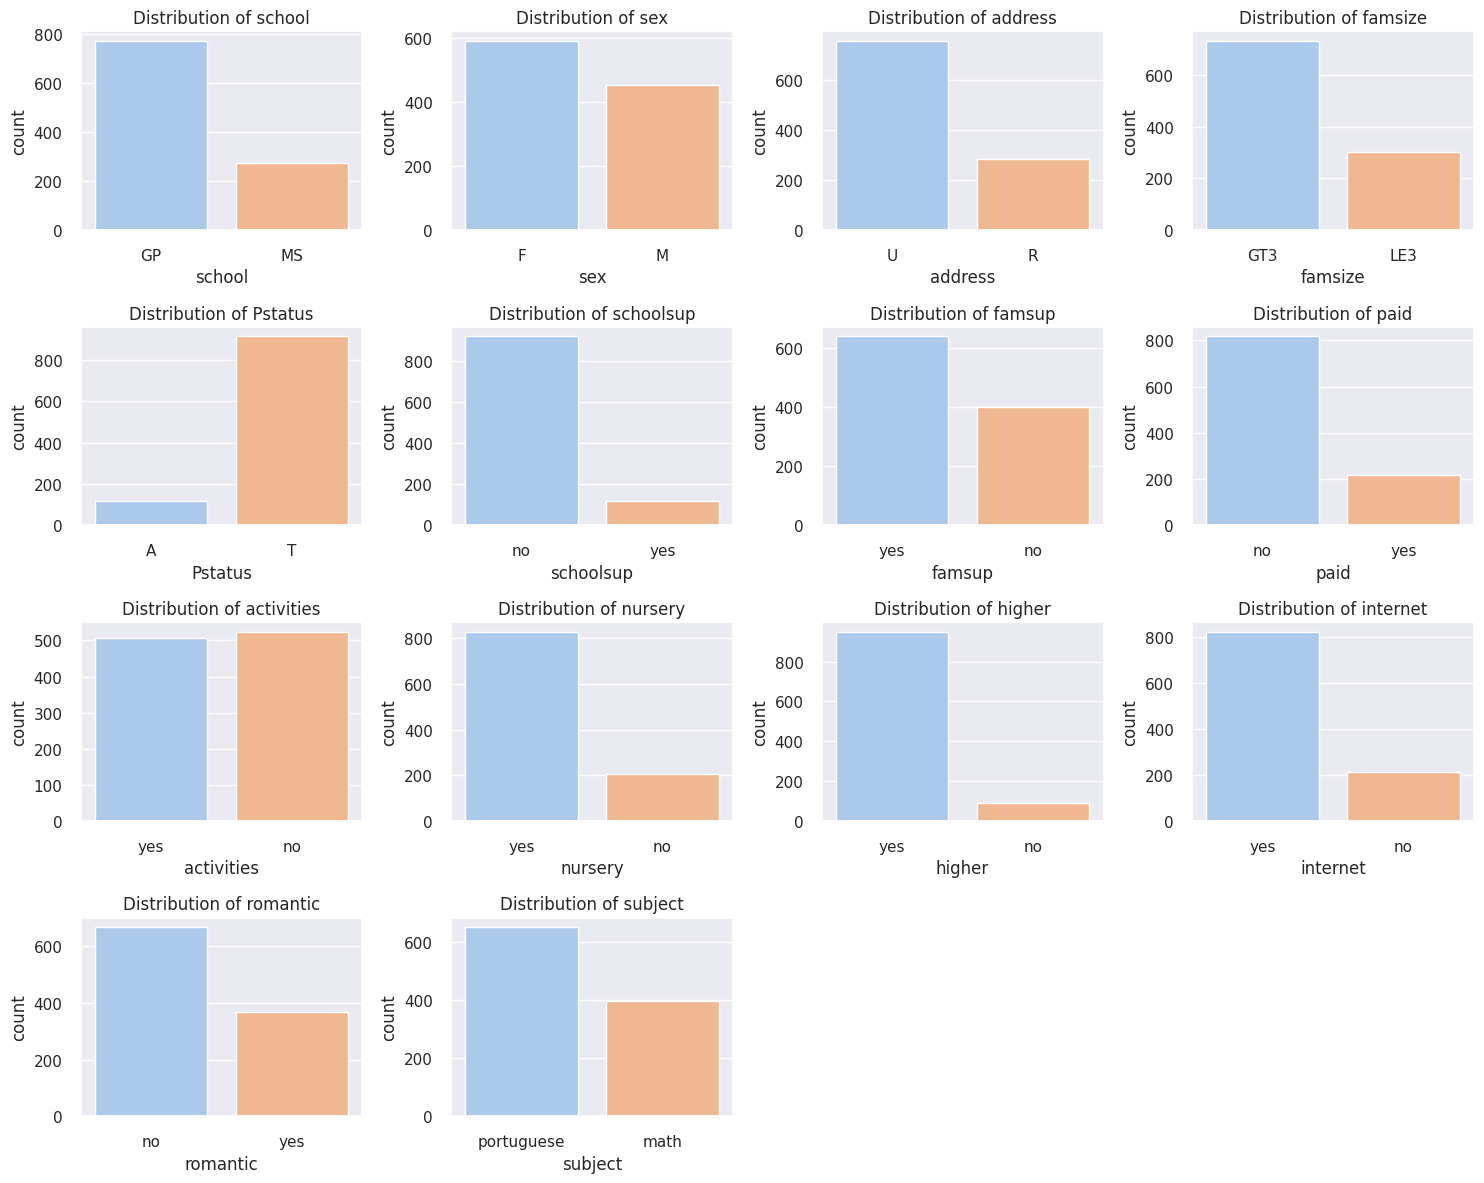

In [11]:
sns.set()
sns.set_palette("pastel")
index = 1

plt.figure(figsize=(15, 12))
for col in df[categorical_columns]:
    column = df[df[col].notnull()][col]
    if len(column.unique()) == 2:
        plt.subplot(4, 4, index)
        sns.countplot(data=df, x=col, legend=False, hue=col)
        plt.title(f"Distribution of {col}")
        
        index += 1

plt.tight_layout()
plt.show()

We can see that some of the columns such as 'activities' are balanced and other like 'Pstatus', 'higher' ... are tipped to one side

Lets also visualize the categorical columns, which have more than 2 unique values

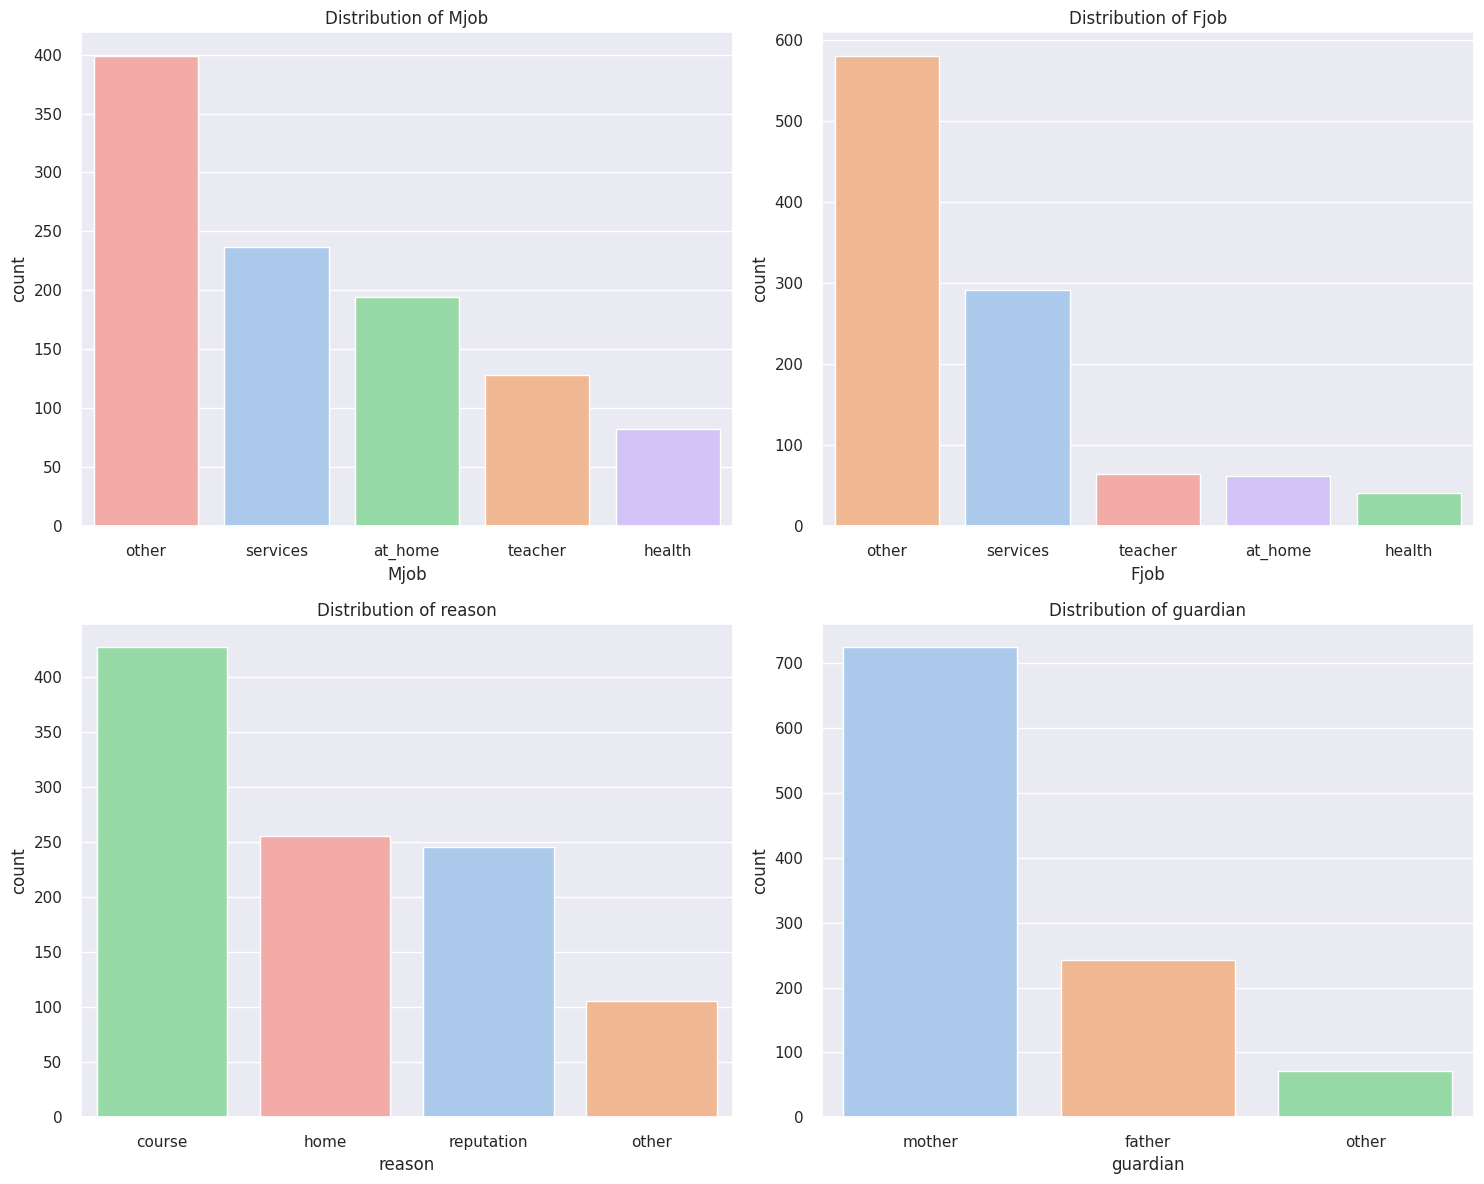

In [12]:
index = 1

plt.figure(figsize=(15, 12))
for col in df[categorical_columns]:
    column = df[df[col].notnull()][col]
    if len(column.unique()) > 2:
        order = column.value_counts().index
        plt.subplot(2, 2, index)
        sns.countplot(data=df, x=col, legend=False, order=order, hue=col)
        plt.title(f"Distribution of {col}")
        
        index += 1

plt.tight_layout()
plt.show()

Here are some interesting insights:
- The majority of the students' mothers are either staying at home or working in service jobs.
- Most of the students' fathers work in service jobs.
- The primary reason for choosing a particular school is course preference.
- The student's guardian is most commonly his mother.

Next, we will take a closer look at **numeric columns**, starting with a basic summary  
We won't consider the id column, since it has no information value for us

In [13]:
numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns
target_columns = ["G1", "G2","G3"]
df[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
age,1036.0,16.726834,1.241666,15.0,16.0,17.0,18.0,22.0
Medu,1034.0,2.596712,1.123036,0.0,2.0,3.0,4.0,4.0
Fedu,1035.0,2.392271,1.101581,0.0,1.0,2.0,3.0,4.0
traveltime,1039.0,1.524543,0.732618,1.0,1.0,1.0,2.0,4.0
studytime,1038.0,1.972062,0.834519,1.0,1.0,2.0,2.0,4.0
failures,1037.0,0.265188,0.657650,0.0,0.0,0.0,0.0,3.0
famrel,1037.0,3.936355,0.930914,1.0,4.0,4.0,5.0,5.0
freetime,1043.0,3.201342,1.031983,1.0,3.0,3.0,4.0,5.0
goout,1035.0,3.158454,1.155264,1.0,2.0,3.0,4.0,5.0
Dalc,1030.0,1.488350,0.905313,1.0,1.0,1.0,2.0,5.0


Some interesting obervations are
- Failures variable is highly imbalanced with most students having 0 failures
- Target variables G1, G2 and G3 exhibit similar values

We can also look at the distributions

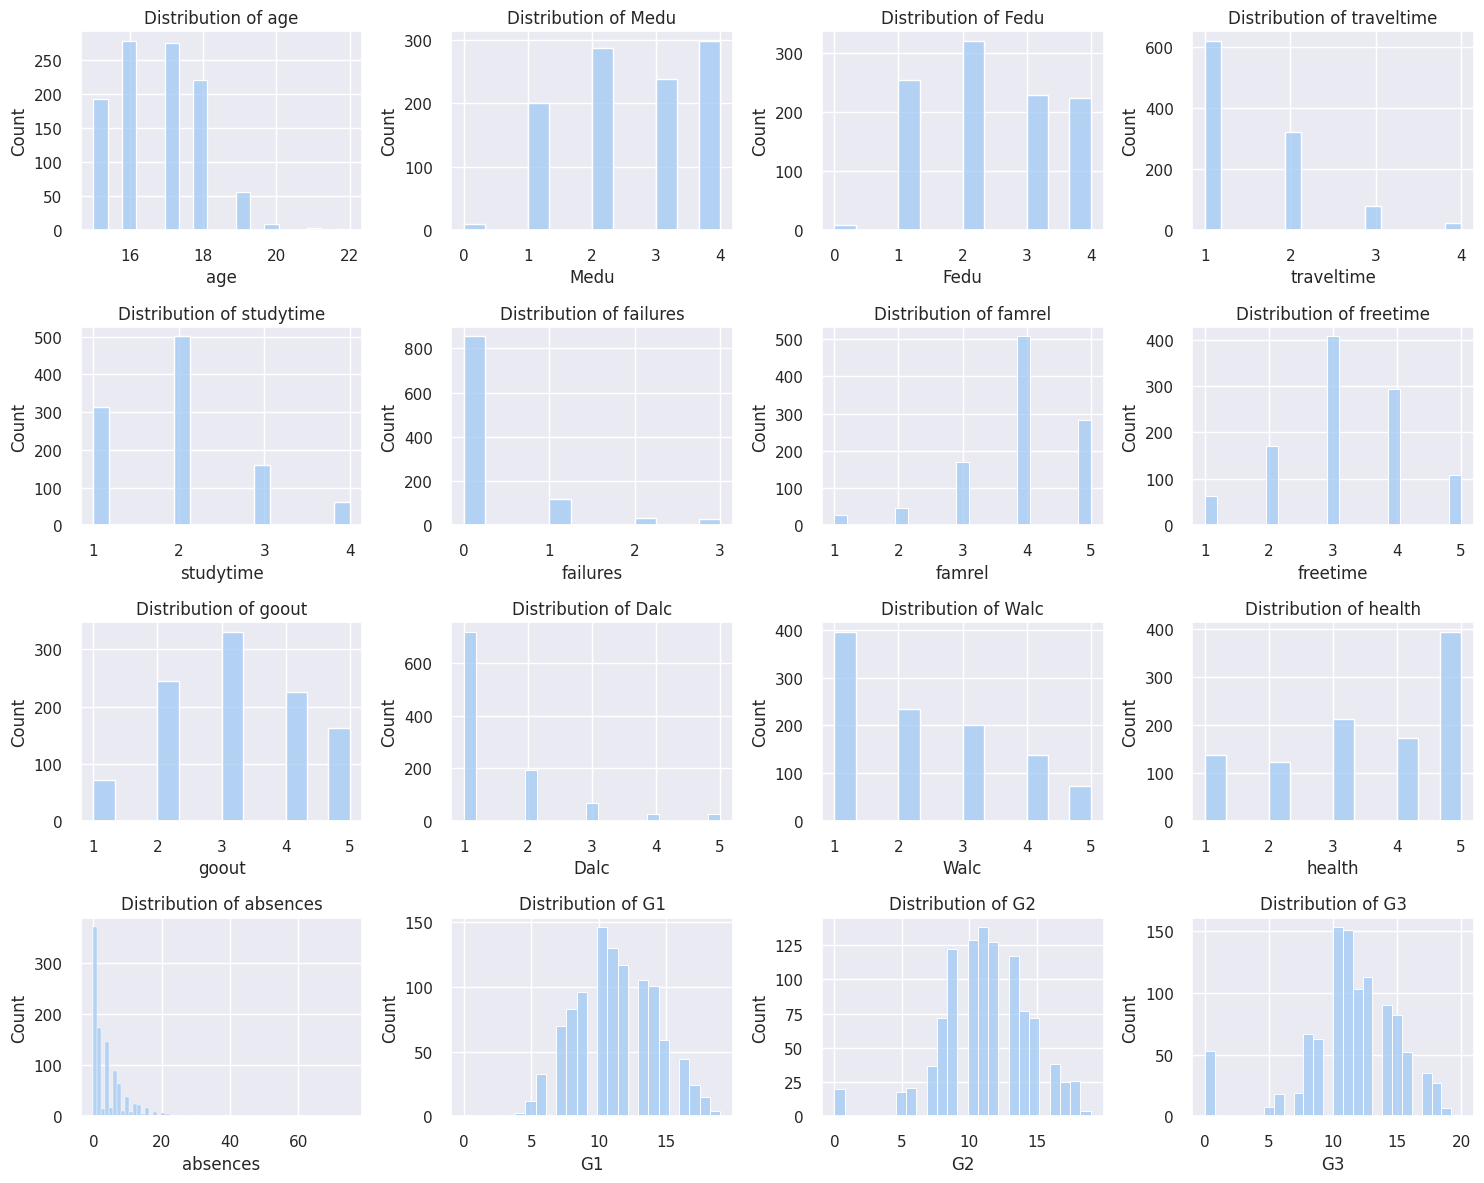

In [14]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(data=df, x=col)
    plt.title(f"Distribution of {col}")
    
plt.tight_layout()
plt.show()

We can also visualize the distributions using boxplots

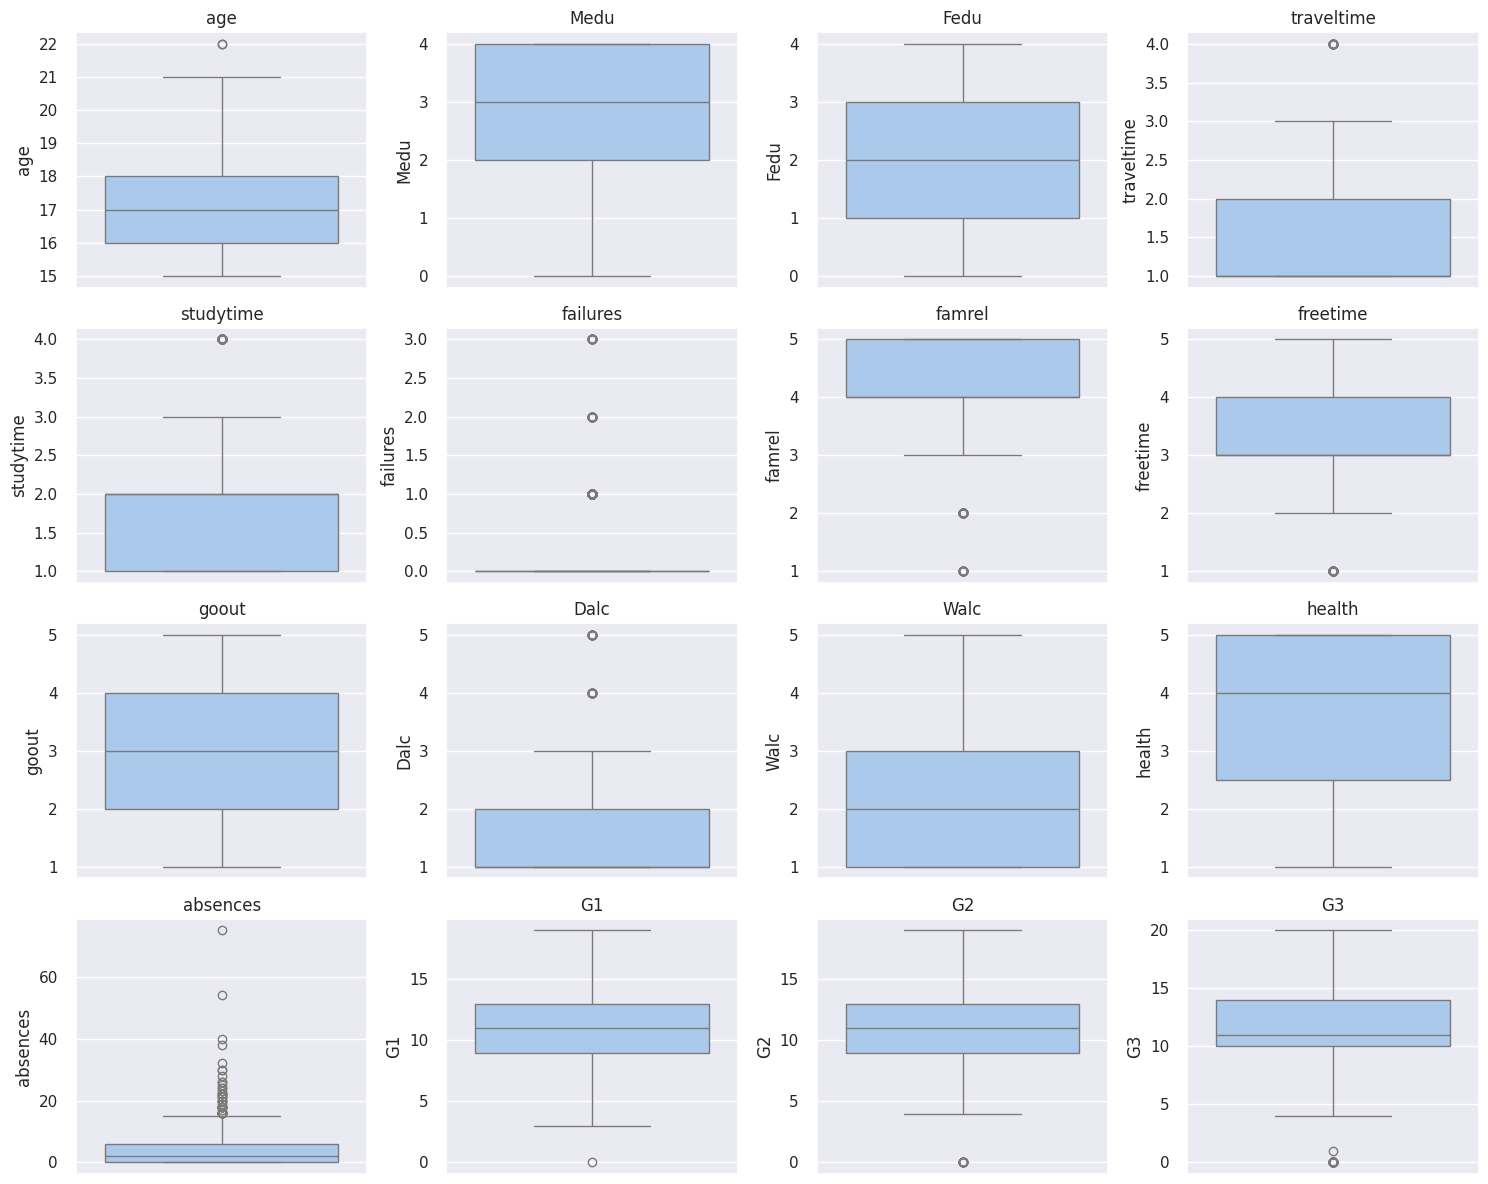

In [15]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=df, y=col)
    plt.title(f"{col}")
    
plt.tight_layout()
plt.show()

We will also look at linear relationships using a correlation heatmap

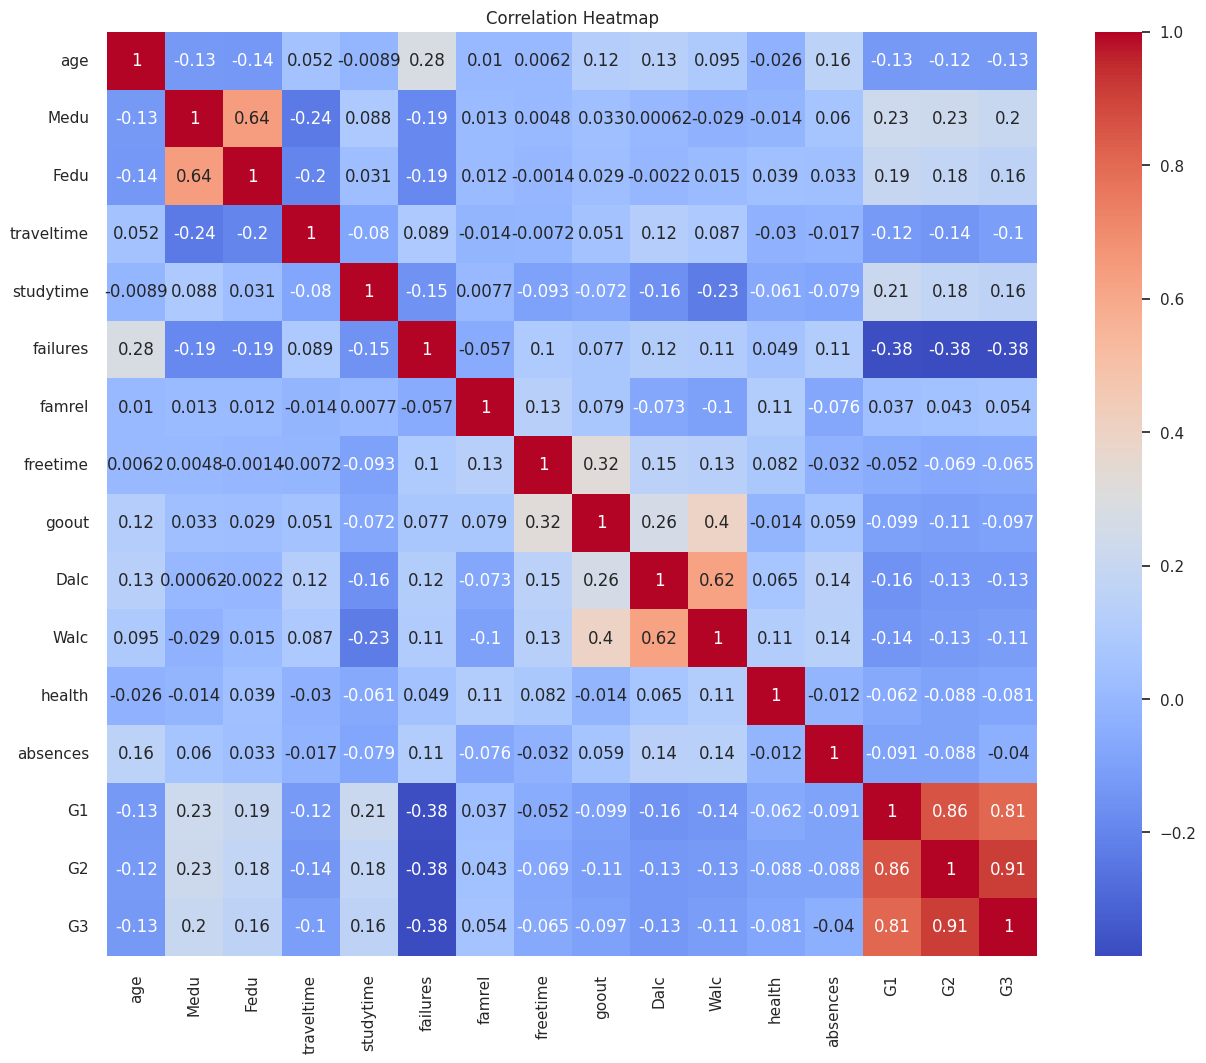

In [16]:
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Target variables G1, G2 and G3 have a strong positive correlation  
Variables describing the workday and weekend alcohol consumption also exhibit a positive correlation, this also applies to father's and mother's education

The strongest negative correlation is between the grades and the number of failures, meaning that people who fail are more likely to get a worse grade

## 2.2 Preprocessing

In [17]:
# Checkpoint to reset preprocessing

df = pd.read_excel("../data/unprocessed.xlsx")
assert df.shape == (1044, 34)

As our first preprocessing step, we will change the dtype from 'object' to 'category'

In [18]:
for col in categorical_columns:
    df[col] = df[col].astype("category")
    
df[categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   school      1044 non-null   category
 1   sex         1044 non-null   category
 2   address     1041 non-null   category
 3   famsize     1037 non-null   category
 4   Pstatus     1034 non-null   category
 5   Mjob        1040 non-null   category
 6   Fjob        1038 non-null   category
 7   reason      1035 non-null   category
 8   guardian    1038 non-null   category
 9   schoolsup   1039 non-null   category
 10  famsup      1039 non-null   category
 11  paid        1037 non-null   category
 12  activities  1031 non-null   category
 13  nursery     1034 non-null   category
 14  higher      1039 non-null   category
 15  internet    1036 non-null   category
 16  romantic    1034 non-null   category
 17  subject     1044 non-null   category
dtypes: category(18)
memory usage: 20.9 KB


### Missing Values

For categorical data, we will use SimpleImputer with "most frequent" strategy

In [19]:
simple_imputer = SimpleImputer(strategy="most_frequent")

for col in categorical_columns:
    df[[col]] = simple_imputer.fit_transform(df[[col]])

For numeric variables, since there are not a lot of missing data, IterativeImputer would be the best choice

In [20]:
iterative_imputer = IterativeImputer()

for col in numeric_columns:
    df[[col]] = iterative_imputer.fit_transform(df[[col]])
    
# Check that there are no more missing values in our dataset
missing_values = df.isnull().sum()
assert len(missing_values[missing_values > 0]) == 0

### Encoding

We will use a LabelEncoder for "binary" columns. 

Note: The following was done only for Ridge Regression, other models worked with the mentioned attributes defaultly encoded.

For yes/no columns, it makes sense to encode 'yes' as 1 and 'no' as 0. Other binary columns cannot be interpreted as values, so a random labelling is ok. For example, it does not make sense to consider an urban address as 1 and a rural address as 0; they are not ordinal values. The exception is the famsize column, where there are 2 strings, but they express family size, so the larger family (GT3) should be 1 and the smaller one (LE3) 0.

In [21]:
label_encoder = LabelEncoder()
binary_columns = [col for col in categorical_columns if len(df[df[col].notnull()][col].unique()) == 2]

for col in binary_columns:
    unique_vals = df[col].dropna().unique()
    
    # ensure that 'yes' is always labeled as 1 and 'no' always as 0
    if set(unique_vals) == {'yes', 'no'}:
        df[col] = df[col].map({'no': 0, 'yes': 1})

    # larger family is '1' and smaller is '0'
    elif set(unique_vals) == {'LE3', 'GT3'}:
        df[col] = df[col].map({'LE3': 0, 'GT3': 1})

    else:
        df[col] = label_encoder.fit_transform(df[col])
    
df[binary_columns].head()

,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,subject
0,0,0,1,1,0,0,1,0,1,1,1,1,0,1
1,0,1,0,1,1,0,1,0,1,1,1,1,1,1
2,1,0,0,0,1,0,0,0,1,1,0,1,0,1
3,0,0,1,1,1,0,1,0,1,1,1,1,0,1
4,0,0,1,1,1,0,0,0,1,1,1,1,1,1


And OneHotEncoder for columns that have more than 2 unique values

In [22]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
nonbinary_columns = [col for col in categorical_columns if col not in binary_columns]

one_hot_encoded_data = one_hot_encoder.fit_transform(df[nonbinary_columns])
one_hot_encoded_columns = one_hot_encoder.get_feature_names_out(nonbinary_columns)

# Create a df from the encoded data and columns
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_data, columns=one_hot_encoded_columns)

# Transform the original df
df = pd.concat([df.drop(columns=nonbinary_columns), one_hot_encoded_df], axis=1)

In [23]:
df.shape

(1044, 47)

We have transformed the original 4 "nonbinary" categorical columns to 17 new encoded ones

### Scaling the Data

Lets continue with scaling our data, we will use a Standard Scaler

In [24]:
exclude_cols = ["G1", "G2", "G3"]
scale_cols = [col for col in df.columns if col not in exclude_cols]

scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

### Splitting the Data

In [25]:
X, y = df.drop(columns=["G1", "G2", "G3"]), df["G3"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape} {y_train.shape}")
print(f"Test  shape: {X_test.shape} {y_test.shape}")

Train shape: (835, 44) (835,)
Test  shape: (209, 44) (209,)


### Baseline Model

In [26]:
for strategy in ["mean", "median"]:
    dummy_regr = DummyRegressor(strategy=strategy)
    dummy_regr.fit(X_train, y_train)
    dummy_pred = dummy_regr.predict(X_test)
    print(f"RMSE using strategy {strategy}: {root_mean_squared_error(y_test, dummy_pred):.3f}")

RMSE using strategy mean: 3.661
RMSE using strategy median: 3.700


# RIDGE REGRESSION

This denotes the start of the section for the Ridge regression model.

## 2.3 Model Selection

The target attribute G3 is not continuous, however, it is ordinal (from 0 to 20), so we should choose a regression model.
I chose Ridge Regression, which adresses the problem of multicollinearity; during EDA, we found several cases of variables correlating - and it also made sense that they correlated. Here are some examples of the correlations: age and number of falures, workday and weekend alcohol consumption, going out and alcohol consumption, free time and going out, mother's education and father's education.

## 2.4 Model Description

Like I already mentioned, Ridge regression focuses on the problem of multicollinearity of predictor variables. It also aims to address overfitting. To solve both problems, Ridge regression uses the OLS (ordinary least squares) function with an added L2 regularization term - the hyperparameter 'alpha'. This penalizes and reduces the variance of large coefficients, meaning that the model will be more stable and less likely to overfit.

Ridge is based on linear regression. In fact, when the hyperparameter 'alpha' is equal to 0, the objective is the same as OLS, meaning that the model acts exactly like linear regression. Ridge gives the same kinds of results as linear regression. The model outputs learned coefficients and the intercept, which together give a linear equation.

## 2.5 Training the Model

Probably the most common way to find the best alpha hyperparameter is through cross-validation. I chose this approach as well, and worked with the sklearn model Ridge CV, which has the cross-validation already built-in.

In [27]:
from sklearn.linear_model import RidgeCV

I also had to choose the number of folds for the cv, the scoring and the candidates for the alpha hyperparameter. For the CV, 5 is considered a common default, so I chose that. In case the ordering of the entries in the dataset was not random, I shuffled it using KFold. 

In [28]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

As for the alpha candidates, they should be exponentially distributed and a good span would be from 0.1 to 100 for about 10-20 values, so I chose 15 values. 

In [29]:
alpha_cand = np.logspace(-1, 2, 15) # from 10**(-1) to 10**2 spanning 15 values

As scoring for the CV, I chose RMSE because that will be the measure to compare with the baseline model as well. I made a scorer using 'make_scorer' and 'mean_squared_error'.

In [30]:
from sklearn.metrics import make_scorer 
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

Now I could build the entire RidgeCV. Despite doing validation, it is important to exclude the testing part of the dataset because the best found 'alpha' still has to be tested somehow.

In [31]:
ridge_cv = RidgeCV(alphas=alpha_cand, scoring=rmse_scorer, cv=cv)
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([  0.1       ,   0.16378937,   0.26826958,   0.43939706,
         0.71968567,   1.17876863,   1.93069773,   3.16227766,
         5.17947468,   8.48342898,  13.89495494,  22.75845926,
        37.2759372 ,  61.05402297, 100.        ]),
        cv=KFold(n_splits=5, random_state=42, shuffle=True),
        scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

We can see what the best alpha out of the candidates is.

In [31]:
print("Best alpha:", ridge_cv.alpha_)

Best alpha: 100.0


The model chose the biggest alpha as the best. This may indicate that a higher value of alpha might be even better. Let's give the alpha candidates a higher limit.

In [32]:
alpha_cand = np.logspace(2, 3, 15) # The range is now from 100 to 1000

ridge_cv = RidgeCV(alphas=alpha_cand, scoring=rmse_scorer, cv=cv)
ridge_cv.fit(X_train, y_train)
print("Best alpha:", ridge_cv.alpha_)

Best alpha: 138.94954943731375


The shuffle had the same random state, and the previous best alpha 100 was included here as well (as the lower limit). This means that the best overall performance on the training data was with alpha = 138.94954943731375.

I also visualized the evaluated alpha values using a graph. However, I could not find a way to do this with the RidgeCV, so I had to use the original.

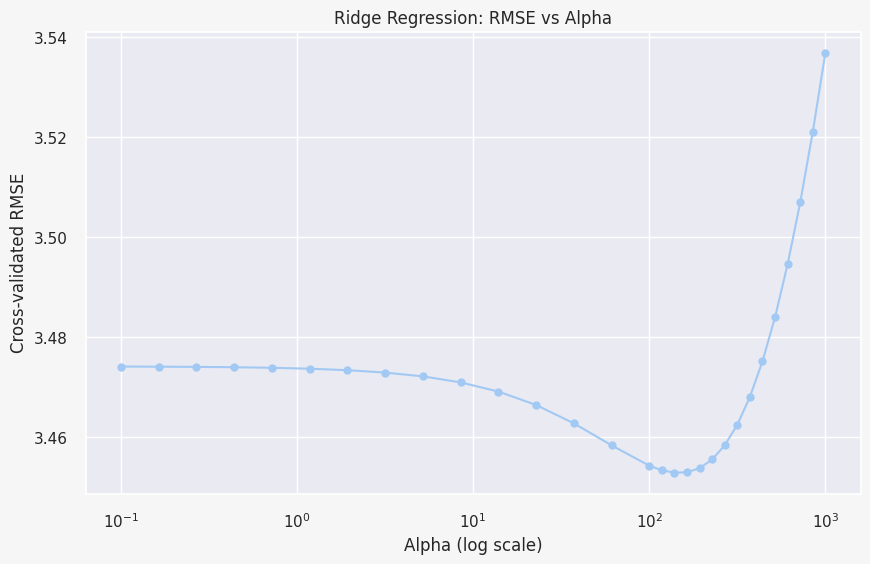

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

rmse_scores = {}

alpha_cand = np.concatenate([np.logspace(-1, 2, 15), (np.logspace(2, 3, 15)[1:])])

for alpha in alpha_cand:
    ridge = Ridge(alpha=alpha)
    neg_mse = cross_val_score(ridge, X_train, y_train, 
                              scoring="neg_mean_squared_error", 
                              cv=cv)
    rmse = (np.sqrt(np.mean(-neg_mse)))
    rmse_scores[alpha] = rmse


alphas_sorted = sorted(rmse_scores)
scores_sorted = [rmse_scores[a] for a in alphas_sorted]

plt.figure(figsize=(10, 6), facecolor='#f6f6f6')
plt.plot(alphas_sorted, scores_sorted, marker="o")
plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Cross-validated RMSE")
plt.title("Ridge Regression: RMSE vs Alpha")
plt.grid(True)
plt.show()

Now it looks like we approached the value of alpha that gives the minimal (the best) RMSE.

 ## 2.6 Model Interpretation

#### alpha = 138.94954943731375

The model chose what is considered a high value of alpha, meaning that it relies on strong regularization.

#### Top Ridge Coefficients

We will look at the 20 most influeantial coefficients.

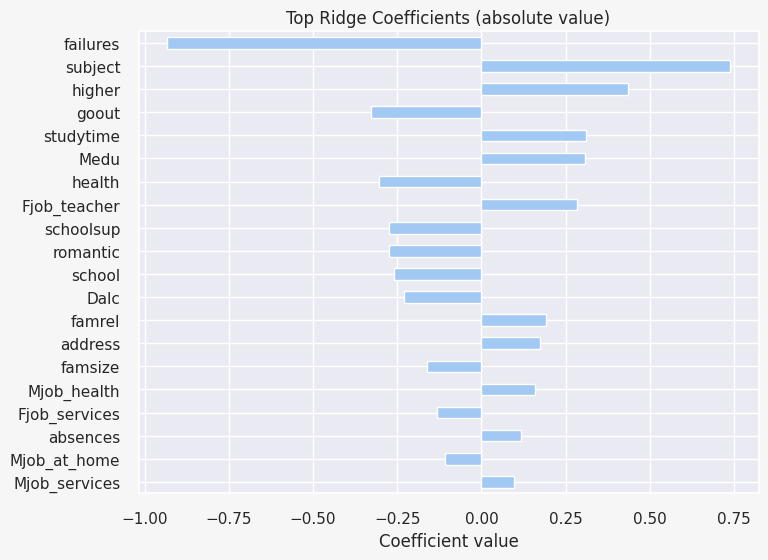

In [34]:
coef_series = pd.Series(ridge_cv.coef_, index=X_train.columns)
sorted_coefs = coef_series.reindex(coef_series.abs().sort_values(ascending=False).index)

plt.figure(figsize=(10, 6), facecolor='#f6f6f6')
sorted_coefs[:20].plot(kind='barh', figsize=(8, 6))
plt.title("Top Ridge Coefficients (absolute value)")
plt.xlabel("Coefficient value")
plt.gca().invert_yaxis()  # highest at the top
plt.show()

The binary attributes that were not yes/no should not be interpreted as negative or positive correlation, but only in the absolute value. These attributes are school, sex, address, subject, and pstatus. This is explained in the Encoding sbsection of the section 2.2 Preprocessing.

I will discuss the top 3 attributes.

Failures have the most impact on the predictions, and it is a negative impact. If a student failed before, they are likely to fail again.

Subject is one of the binary attributes, so we have to analyse it more.
    LabelEncoder encodes in alphabetical order, meaning that 'Math' was encoded as '0' and Portugese as '1'.
    The positive coefficient means that the model predicts a better grade to those who study Portugese. It makes sense since math is usually considered a difficult subject.

Higher - students who aim for higher education (have bigger ambitions) are more likely to succeed. This makes sense because abmitions often come with better skill.

#### Correlating coefficients

I also want to point out the attributes that correlated with each other. This relates to the previously mentioned multicollinearity. For father's education and mother's education, which highly correlated, it gave a big coefficient to the mother and the father is not in the top 20. This is what we can expect Ridge to do, because it should avoid giving 2 correlating attributes big rating (to both). This is also true for: workday and weekend alcohol consumption, going out and weekend alcohol consumption, age and failures, going out and free time.

## 2.7 Model Evaluation

The baseline model (in the section 2.2 Preprocessing) had an RMSE value of 3.661 using strategy mean and 3.700 using strategy median. We eill now test the Ridge model.

In [35]:
y_pred = ridge_cv.predict(X_test)

rmse_test = (root_mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse_test)

Test RMSE: 3.284588364989505


The result is a smaller RMSE, which means that it performed better than the baseline model, but not by much. The score for the test data is better than during validation (according to the graph, it was cca 3.45). The difference is small, so this can be explained by the cross-validation process. Due to multiple random data splits, it is likely to include more noise than the test data.

I also tested the model for R-squared, where the baseline is 0, the best possible result is 1, and -1 is the worst.

In [36]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2}")

R² Score: 0.18397684174090634


This also indicates that the Ridge model performs slightly better than the baseline.

Overall, I expect other models to perform better. The results were only a little better than the baseline in both metrics. Nevertheless, the model did correctly choose to give the biggest (absolute) coefficients to attributes that make sense as deciding factors. It also did avoid overfitting and multicollinearity, which it should.

In [37]:
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error


def evaluate_model(y_pred, y_test, model_name):
    print(f"\nEvaluation of {model_name}:")
    print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")
    print(f"MAE:  {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"R2:   {r2_score(y_test, y_pred):.4f}")

evaluate_model(y_pred, y_test, 'Ridge')


Evaluation of Ridge:
RMSE: 3.2846
MAE:  2.4008
R2:   0.1840


## XGBoost Regressor
https://xgboost.readthedocs.io/en/release_3.0.0/

XGBoost (eXtreme Gradient Boosting) is an advanced machine learning technique based on gradient-boosted decision trees. During training, the model builds an ensemble of weak prediction trees sequentially, where each new tree corrects errors made by the previous ones. The algorithm optimizes a user-defined loss function (e.g., mean squared error for regression or log loss for classification) while incorporating regularization terms (L1/L2 penalties) to prevent overfitting. Key computations include calculating gradients (first-order derivatives) and Hessians (second-order derivatives) of the loss function, which guide the tree-building process by determining optimal splits that minimize the overall loss.

The result of training is a weighted ensemble of decision trees, where each tree contributes a prediction adjusted by a learning rate (shrinkage factor). Unlike random forests, which grow trees independently, XGBoost iteratively refines predictions by focusing on residual errors, leading to higher accuracy. The final model combines predictions from all trees, balancing bias and variance through techniques like pruning, early stopping, and cross-validation. XGBoost’s efficiency stems from its parallelizable tree construction and handling of sparse data, making it a powerful tool for structured datasets.

#### Data Preparation

In [28]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [29]:
# We will use this function to evaluate our model

def evaluate_model(y_pred, model_name):
    y_true = y_test
    
    print(f"\nEvaluation of {model_name}:")
    print(f"RMSE: {root_mean_squared_error(y_true, y_pred):.4f}")
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R2:   {r2_score(y_true, y_pred):.4f}")

#### Baseline Model

In [30]:
baseline_mean = DummyRegressor(strategy="mean")
baseline_mean.fit(X_train, y_train)
y_pred = baseline_mean.predict(X_test)
evaluate_model(y_pred, "baseline mean model")

baseline_median = DummyRegressor(strategy="median")
baseline_median.fit(X_train, y_train)
y_pred = baseline_median.predict(X_test)
evaluate_model(y_pred, "baseline median model")


Evaluation of baseline mean model:
RMSE: 3.6611
MAE:  2.7043
R2:   -0.0139

Evaluation of baseline median model:
RMSE: 3.6999
MAE:  2.7129
R2:   -0.0354


#### Initial Model Training

In [31]:
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": 42
}

initial_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10
)

y_pred = initial_model.predict(dtest)
evaluate_model(y_pred, "initial xgboost model")

[0]	train-rmse:3.41984	test-rmse:3.43435
[10]	train-rmse:1.99436	test-rmse:3.38653
[20]	train-rmse:1.54362	test-rmse:3.42970
[30]	train-rmse:1.29892	test-rmse:3.45680
[40]	train-rmse:1.06109	test-rmse:3.49887
[50]	train-rmse:0.83789	test-rmse:3.51103
[51]	train-rmse:0.83632	test-rmse:3.51048

Evaluation of initial xgboost model:
RMSE: 3.5105
MAE:  2.5724
R2:   0.0679


#### Hyperparameter Tuning

In [32]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

param_grid = {
    "max_depth": [2, 3, 4],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1],
    "min_child_weight": [1, 2],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [0, 0.1, 1]
}


grid_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    n_iter=500
)

grid_search.fit(X_train, y_train)

print("\nBest parameters found:")
for k, v in grid_search.best_params_.items():
    print(f"{k}: {v}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
evaluate_model(y_pred, "tuned xgboost model")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits

Best parameters found:
subsample: 0.8
reg_lambda: 0
reg_alpha: 0.1
min_child_weight: 1
max_depth: 3
learning_rate: 0.05
gamma: 0
colsample_bytree: 1.0

Evaluation of tuned xgboost model:
RMSE: 3.2529
MAE:  2.4256
R2:   0.1996


#### Model Interpretation

In [ ]:
plt.figure(figsize=(10, 6), facecolor='#f6f6f6')
xgb.plot_importance(best_model.get_booster(), importance_type="weight", max_num_features=10)
plt.title("Feature Importance (Top 10)")
plt.tight_layout()
plt.show()

In [34]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

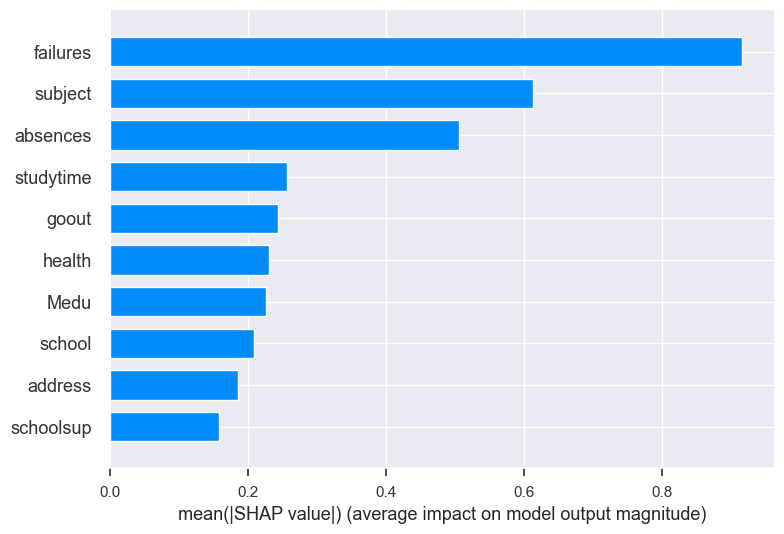

<Figure size 800x550 with 0 Axes>

In [35]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, rng=42)
plt.tight_layout()
plt.show()

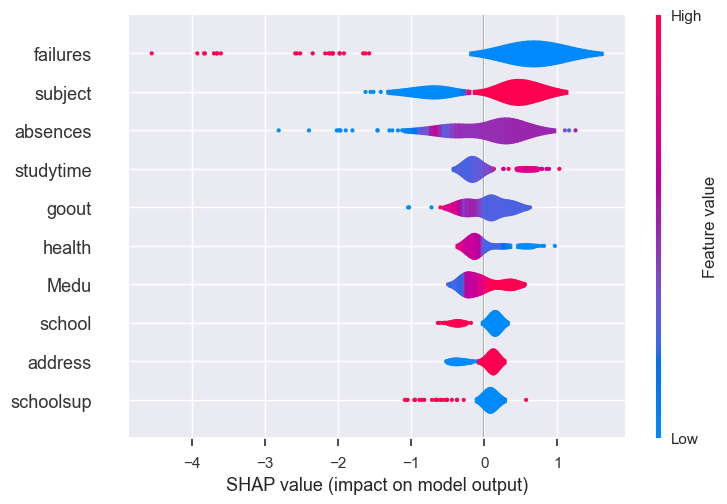

<Figure size 800x550 with 0 Axes>

In [36]:
plt.figure(figsize=(10, 6))
shap.plots.violin(shap_values, X_test, max_display=10)
plt.tight_layout()
plt.show()

#### Validation Curve

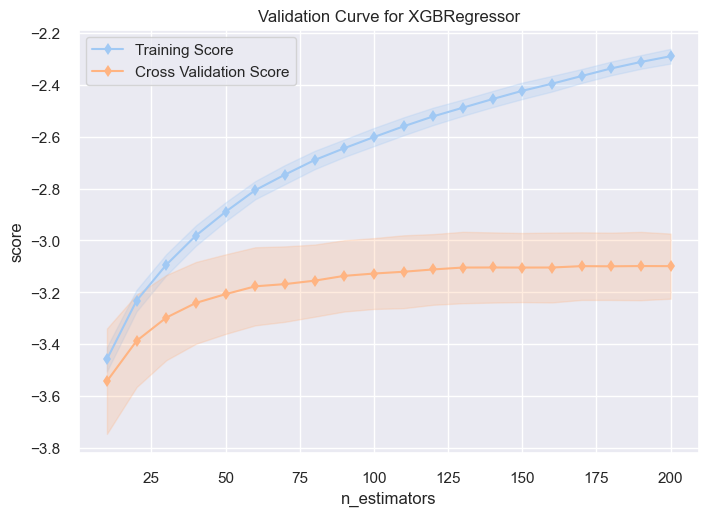

In [37]:
viz = validation_curve(
    xgb.XGBRegressor(**grid_search.best_params_),
    X_train, y_train,
    param_name="n_estimators",
    param_range=np.arange(10, 201, 10),
    cv=5,
    scoring="neg_root_mean_squared_error", 
    n_jobs=-1,
)

viz.show()
plt.show()

#### Final Model Evaluation

In [38]:
final_model = xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=42,
    n_estimators=60
)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

evaluate_model(y_pred, "final xgboost model")


Evaluation of final xgboost model:
RMSE: 3.2408
MAE:  2.4227
R2:   0.2056


We can plot the first two trees to get some idea on how the model operates

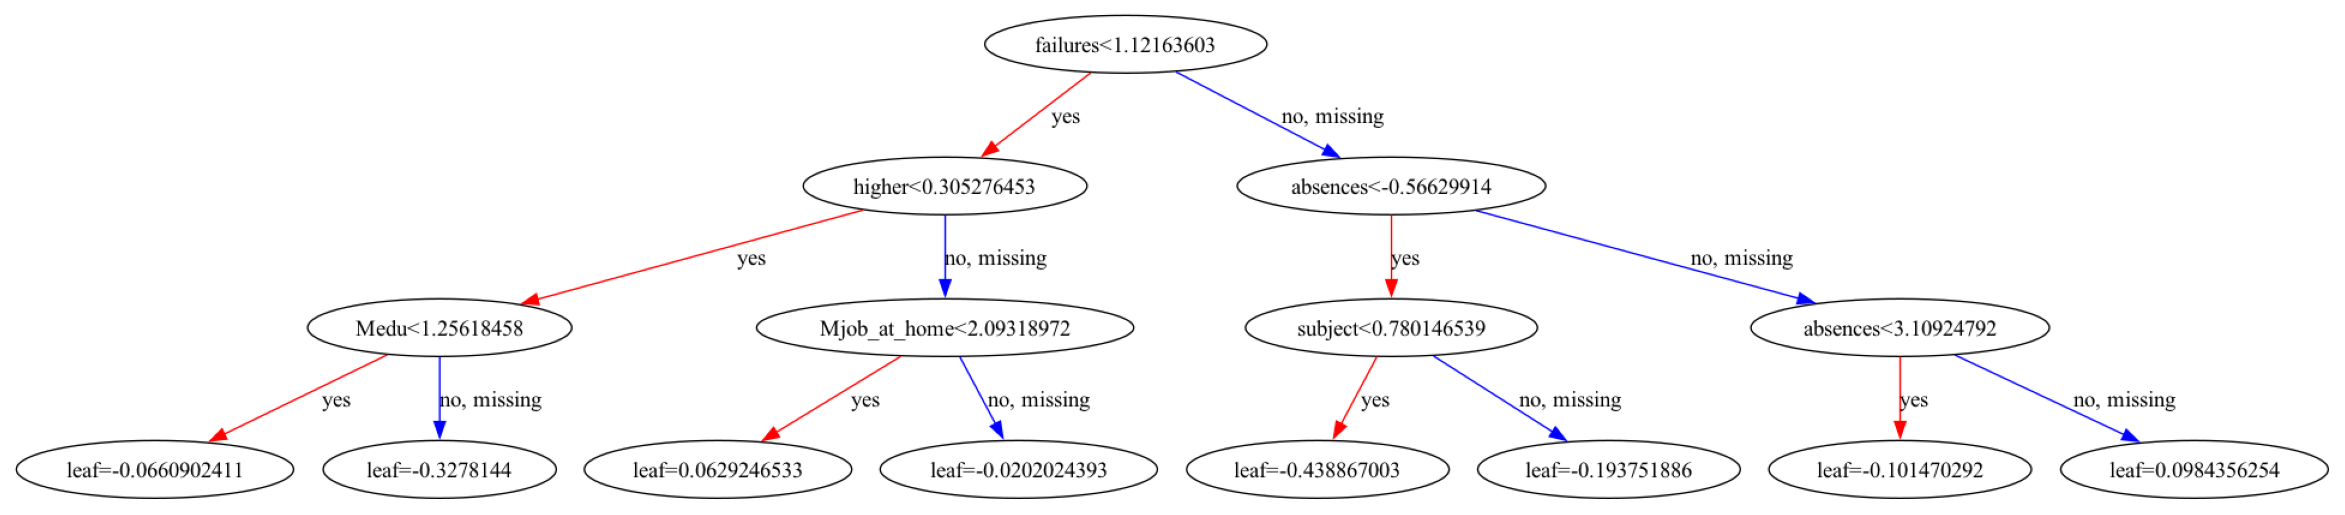

In [39]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(final_model, tree_idx=0, ax=ax)
plt.show()

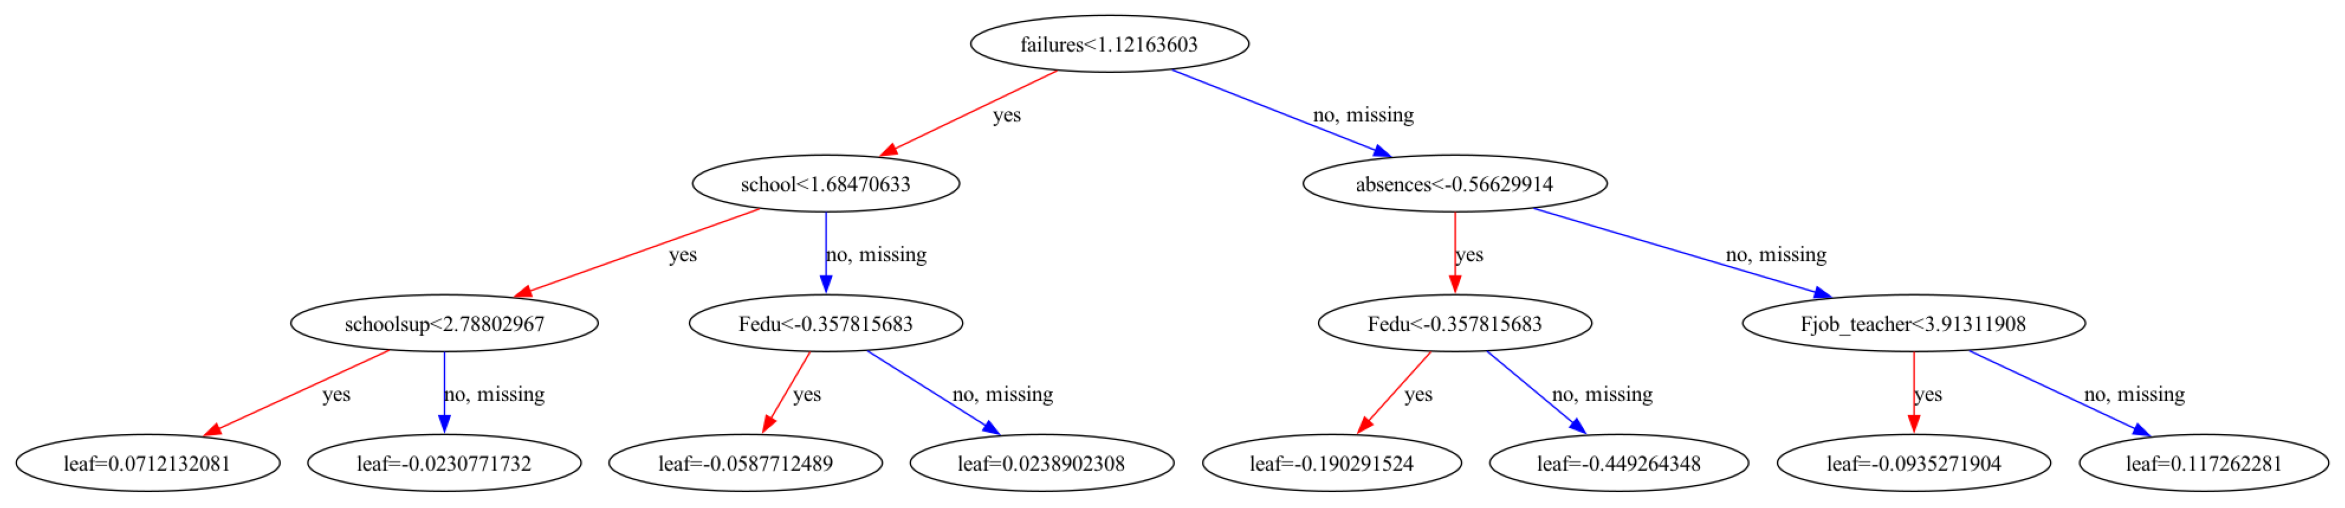

In [40]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(final_model, tree_idx=1, ax=ax)
plt.show()

#### Residual Analysis

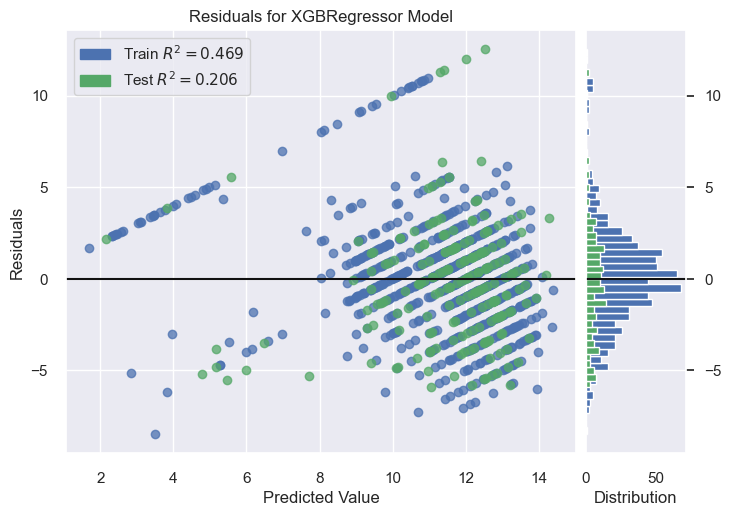

In [41]:
visualizer = ResidualsPlot(final_model)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
visualizer.show()
plt.show()

#### Prediction Error

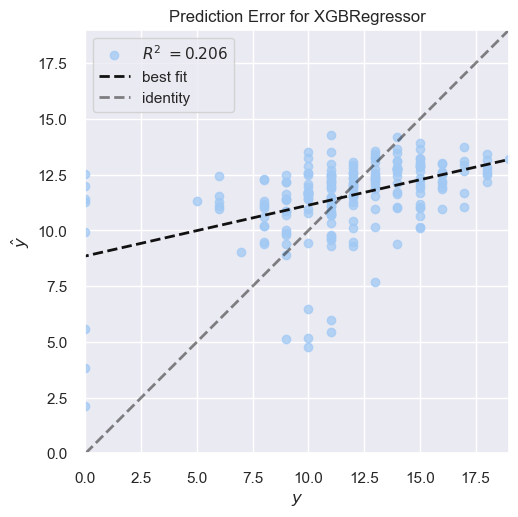

In [42]:
visualizer = PredictionError(final_model)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
visualizer.show()
plt.show()

#### Learning Curve

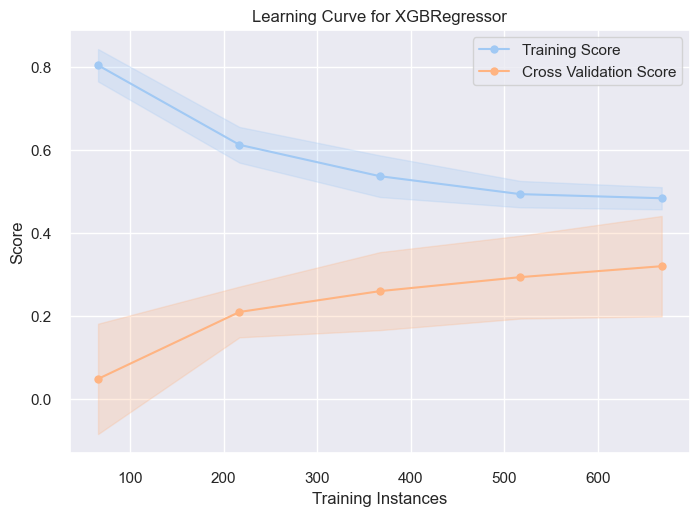

In [45]:
visualizer = LearningCurve(final_model, scoring="r2")
visualizer.fit(X_train, y_train)        
visualizer.show() 
plt.show()

# Support Vector Machine (SVM)

A **Support Vector Machine (SVM)** is a supervised machine learning algorithm primarily used for binary classification tasks. In its simplest form, the **hard-margin linear SVM** aims to find a hyperplane that perfectly separates data points of two classes. The algorithm searches for the hyperplane that maximizes the margin, which is the distance between the hyperplane and the closest data points from each class, called **support vectors**.

To handle cases where perfect separation is not possible, the **soft-margin SVM** introduces flexibility by allowing some data points to be misclassified or lie within the margin. This is achieved through the use of **slack variables**, which measure the degree of violation of the margin constraints. SVMs can also use the **kernel trick** to implicitly map data into a higher-dimensional space to allow even for processing non-linearly seprable data.

In SVMs we classify based on the sign of the linear hyperplane. To use SVMs for regression tasks, we simply use the hyperplane as such, and in training instead of penalizing slack variables, we penalize divergence from the real value which is larger then some epsilon. That is called **epsilon-insenstive loss**.

In [ ]:
from generated import preprocessing

In [3]:
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
X, y = preprocessing.X, preprocessing.y
X_train, X_test, y_train, y_test = preprocessing.X_train, preprocessing.X_test, preprocessing.y_train, preprocessing.y_test

def evaluate_model(y_pred, y_test, model_name):
    print(f"\nEvaluation of {model_name}:")
    print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")
    print(f"MAE:  {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"R2:   {r2_score(y_test, y_pred):.4f}")


### Baseline models

In [4]:
from sklearn.dummy import DummyRegressor

baseline_mean = DummyRegressor(strategy="mean")
baseline_mean.fit(X_train, y_train)
y_pred = baseline_mean.predict(X_test)
evaluate_model(y_pred, y_test, "baseline mean model")

baseline_median = DummyRegressor(strategy="median")
baseline_median.fit(X_train, y_train)
y_pred = baseline_median.predict(X_test)
evaluate_model(y_pred, y_test, "baseline median model")


Evaluation of baseline mean model:
RMSE: 3.6611
MAE:  2.7043
R2:   -0.0139

Evaluation of baseline median model:
RMSE: 3.6999
MAE:  2.7129
R2:   -0.0354


### Model

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

### Hyperparameters

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'svr__C': [1, 10, 100], # 0.01, 0.1
        'svr__epsilon': [0.0001,0.001, 0.01, 0.1], # 0.2, 0.5, 1
        'svr__kernel': ['linear', 'rbf']
    },
    {
        'svr__C': [1, 10, 100], # 0.01, 0.1
        'svr__epsilon': [0.0001,0.001, 0.01, 0.1], # 0.2, 0.5, 1
        'svr__kernel': ['poly'],
        'svr__degree': [2, 3, 4]
    }
]

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [24]:
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", -grid_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'svr__C': 10, 'svr__epsilon': 0.0001, 'svr__kernel': 'rbf'}
Best cross-validation score: 10.314077137727658


### Fixing model and evaluation

In [25]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(C=10, epsilon=0.0001, kernel='rbf'))
]) 

In [26]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

evaluate_model(y_pred, y_test, "SVR")


Evaluation of SVR:
RMSE: 3.1796
MAE:  2.3542
R2:   0.2353


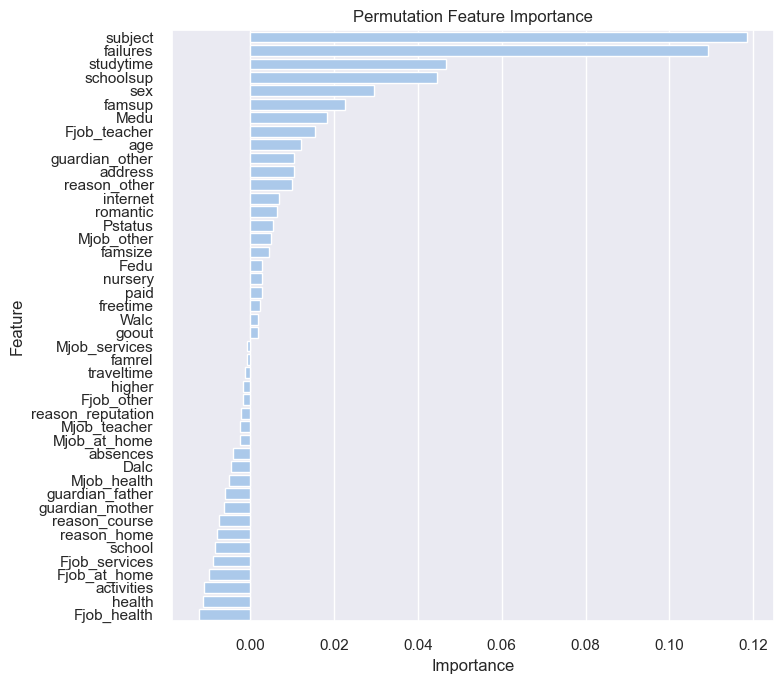

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance


perm_result = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)

# Prepare DataFrame for Seaborn
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_result.importances_mean
}).sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 7))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()


In [29]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    X_train.values, 
    feature_names=X.columns.tolist(), 
    mode='regression', 
    verbose=True, 
    random_state=42
)

In [ ]:
for i in range(5):
    exp = explainer.explain_instance(
        X_test.iloc[i].values, 
        pipeline.predict, 
        num_features=5
    )
    exp.save_to_file(f'./explanations/lime_explanation_{i}.html')

In [ ]:
import shap

def pipeline_predict(X):
    if isinstance(X, pd.DataFrame):
        X = X.values
    return pipeline.predict(X)

X_train_sample = shap.sample(X_train, 100, random_state=42).values

explainer = shap.KernelExplainer(pipeline_predict, X_train_sample)

shap_values = explainer.shap_values(X_test.iloc[:100].values)

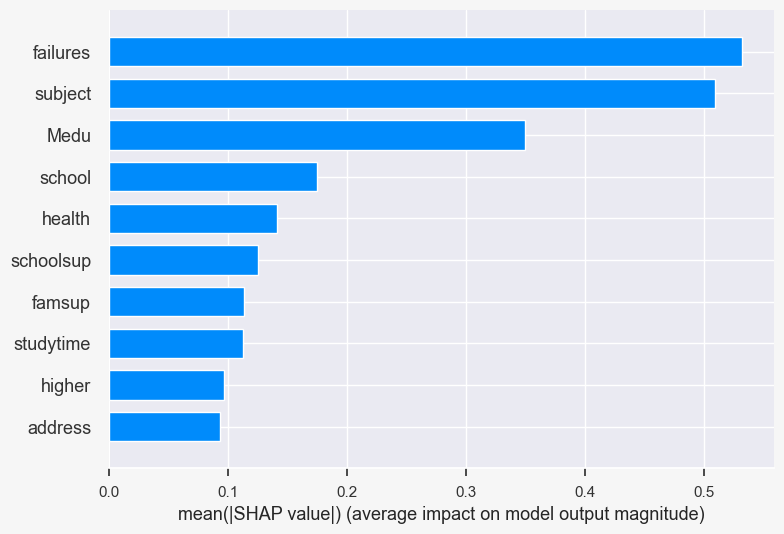

<Figure size 800x550 with 0 Axes>

In [43]:
plt.figure(figsize=(10, 6), facecolor='#f6f6f6')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, rng=42)
plt.tight_layout()

plt.show()

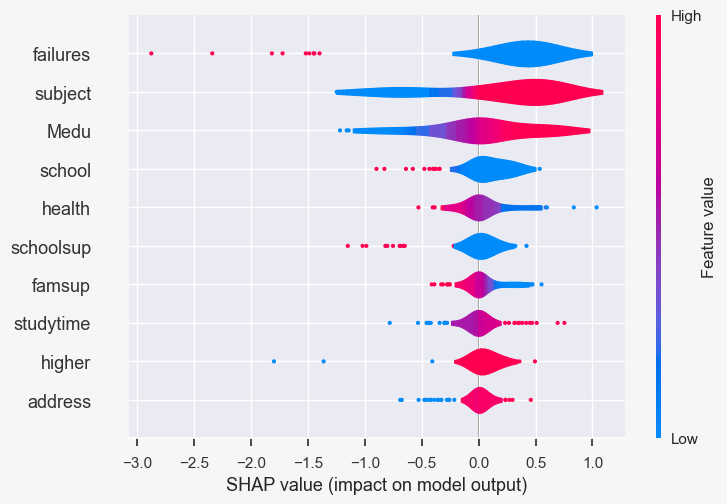

<Figure size 800x550 with 0 Axes>

In [45]:
plt.figure(figsize=(10, 6), facecolor='#f6f6f6')
shap.plots.violin(shap_values, X_test.iloc[:100], max_display=10)
plt.tight_layout()
plt.show()

# Conclusion

To conclude, all of the trained models outperformed the baseline for the measured evaluation rates. However, for the RMSE rate, for example, the models did not outperform the baseline by much. We expected the difference of RMSE to be larger.

The Ridge Regression model was generally outperformed by the SVM and xgboost models; this was expected, as is already mentioned in the individual evaluation of the Ridge model. Based on the results, we believe that the best model is SVM.